# Recitation 10: hyperparameter optimization

* An example of hyperparameter optimization with `hyperopt`

In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import hyperopt

In [3]:
def experiment(p):
    x, y = p
    peak = max(y*(0.8-y), 0)
    act = 5*max(peak*np.sin(np.pi * 2 * -x)+1,0)
    return -np.mean(np.random.normal(act, size=20))

In [4]:
trials = hyperopt.Trials()

best = hyperopt.fmin(
    fn=experiment,
    space=[
        hyperopt.hp.uniform('x', 0, 1.),
        hyperopt.hp.uniform('y', 0, 1.)
    ],
    algo=hyperopt.tpe.suggest,
    max_evals=1000,
    trials=trials,
)

100%|████| 1000/1000 [00:03<00:00, 272.87trial/s, best loss: -6.527363534387844]


In [5]:
best

{'x': 0.8161928377406202, 'y': 0.41034579764893925}

In [6]:
def funky_dist(mean_ms, **kwargs):
    return mean_ms / 1000 * np.random.pareto(2, **kwargs)

You run a website and you put a price on performing an operation on the website. Your price determines the rate at which customers arrive aka come to use your website. So a steeper price means fewer customers will arrive into the system.

You have to get their query done in XX ms and then you make the money that you put up as the price in reward. Otherwise you have to pay a penalty of 10% of the price.

You also choose your capacity (number of servers) which costs $Y per server, but these speed up the service.

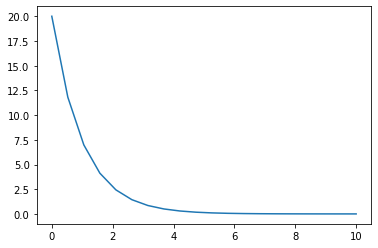

In [7]:
t = np.linspace(0,10,20)
plt.plot(t, 20*(np.exp(-t)))

In [8]:
max_query_time = 100
server_cost = 100

def experiment(price, servers):

    state = {
        "last": 0,
        "i": 0,
        # i-th element tells amount of time with i customers
        "histogram": np.zeros(0),
        "wait_times": [],
    }
    
    def update_hist(state, env, new_i):
        if len(state["histogram"]) <= state["i"]:
            state["histogram"].resize(state["i"]+1)
        state["histogram"][state["i"]] += env.now - state["last"]
        state["last"] = env.now
        state["i"] = new_i

    def requests(state, env, db_connection, qps):
        req_id = 0
        while True:
            req_id += 1
            inter_arrival_time = np.random.exponential(1/qps)
            yield env.timeout(inter_arrival_time)
            env.process(page_load(state, env, db_connection, req_id))

    def do_db_query(state, env, db_connection, mean_duration_ms):
        # note that mean duration is specified in milliseconds (1e-3 s)
        req = db_connection.request()
        yield req
        yield env.timeout(funky_dist(mean_duration_ms))
        db_connection.release(req)

    def page_load(state, env, db_connection, req_id):
        start = env.now
        update_hist(state, env, state["i"] + 1)
    #     print(f"{env.now:5.2f}: starting request id {req_id}")
        # 1: get user details
        yield from do_db_query(state, env, db_connection, 2)
        # 2: get their recipes
        yield from do_db_query(state, env, db_connection, 10)
        # 3: add an ingredient to the recipe
        yield from do_db_query(state, env, db_connection, 25)
        # 4: generate the response object (e.g. format stuff nicely, etc)
        yield env.timeout(funky_dist(5))
        update_hist(state, env, state["i"] - 1)
    #     print(f"{env.now:5.2f}: finished request id {req_id}")
        end = env.now
        state["wait_times"].append(end - start)

    # simulation time will be in seconds!
    env = simpy.Environment()
    db_connection = simpy.Resource(env, capacity=servers)
    env.process(requests(state, env, db_connection, 20*(np.exp(-price))))
    env.run(until=1000)
    wait_times = np.array(state["wait_times"])
    too_slow_queries = np.sum(wait_times > max_query_time)
    adequate_queries = np.sum(wait_times <= max_query_time)
    reward = too_slow_queries * (-0.1 * price) + adequate_queries * price - servers * server_cost
#     p99 = np.quantile(wait_times, .99)
#     print(f"p99 for {servers=} is {p99}")
    return reward
#     p99s.append(p99)

In [9]:
def exp2(parameters):
    return -experiment(*parameters)

In [10]:
trials = hyperopt.Trials()

best = hyperopt.fmin(
    fn=exp2,
    space=[
        hyperopt.hp.uniform('price', 0, 10.),
        hyperopt.hp.quniform('servers', 1, 20, 1)
    ],
    algo=hyperopt.tpe.suggest,
    max_evals=200,
    trials=trials,
)

100%|███████| 200/200 [00:29<00:00,  6.73trial/s, best loss: -7285.564823844887]


In [11]:
best

{'price': 0.9417960754711664, 'servers': 1.0}

In [12]:
experiment(best["price"], best["servers"])

7303.458949278839